In [2]:
!pip install torchinfo -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchinfo import summary
import torch.optim as optim
import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
train_dataset = pd.read_csv('nyc-taxi-trip-duration/train.csv')
df_train = pd.DataFrame(train_dataset)

In [5]:
print(f'No. of records: {df_train.shape[0]}')
print(f'No. of features: {df_train.shape[1]}')
print('\n\n')


print(df_train.describe())


No. of records: 1458644
No. of features: 11



          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.21811

In [6]:
df_train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [7]:
column_types = df_train.dtypes
print(column_types)
print('\n\n Missing Values Count\n\n')
print(df_train.isnull().sum())

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object


 Missing Values Count


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [8]:
def haversine_distance(lat1, long1, lat2, long2):

    earth_radius = 6371

    lat1, long1, lat2, long2 = map(np.radians, (lat1, long1, lat2, long2))

    d_lat = lat2 - lat1
    d_long = long2 - long1

    a = np.sin(d_lat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(d_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    dist = earth_radius * c

    return dist

def add_distance(df):

    df['distance'] = haversine_distance(df['pickup_latitude'],
                                           df['pickup_longitude'],
                                           df['dropoff_latitude'],
                                           df['dropoff_longitude'])

add_distance(df_train)

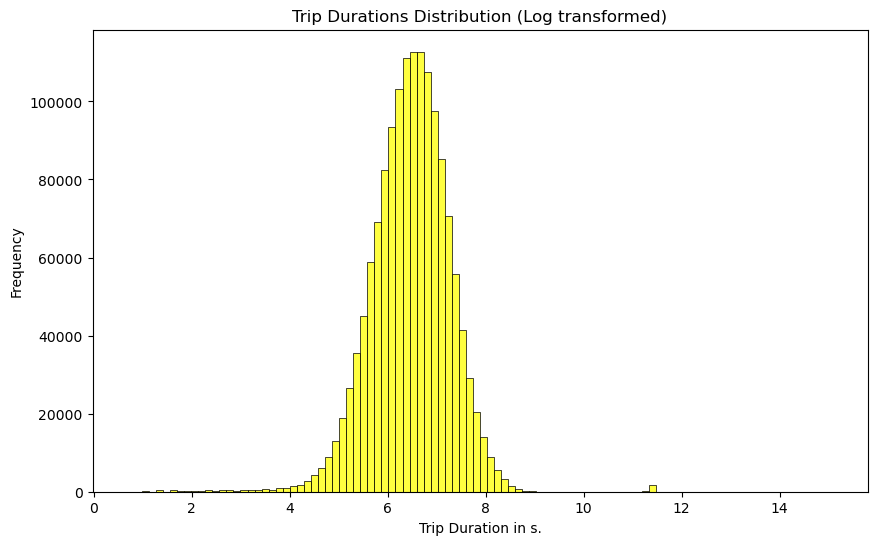

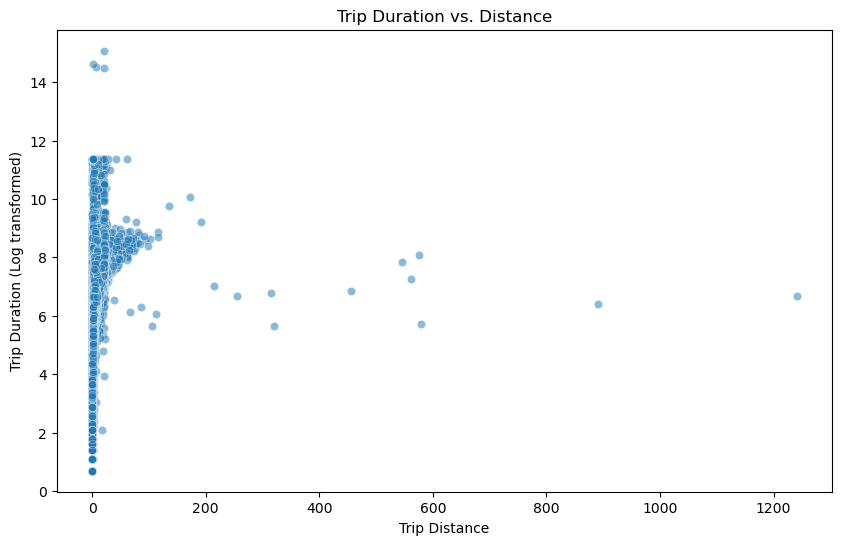

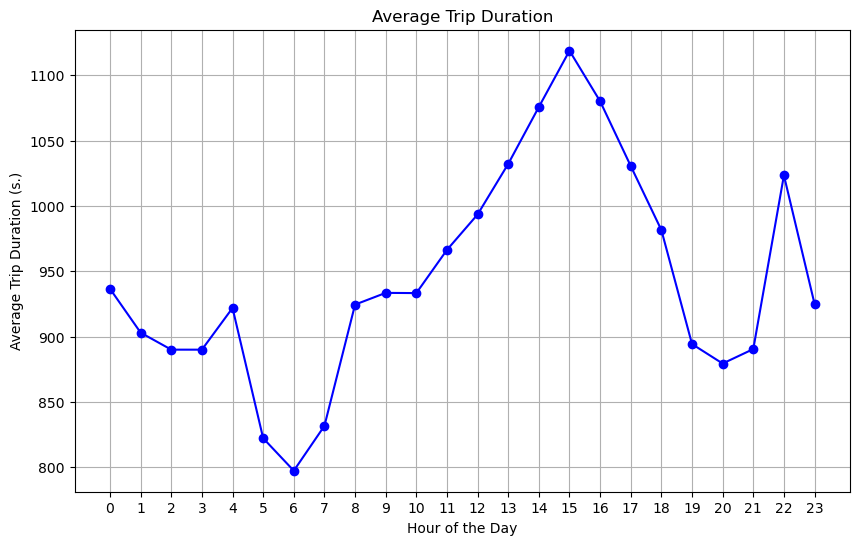

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log(df_train['trip_duration'].values +1), bins=100, color='yellow')
plt.title('Trip Durations Distribution (Log transformed)')
plt.xlabel('Trip Duration in s.')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y=np.log(df_train['trip_duration'].values +1), data=df_train, alpha=0.5)
plt.title('Trip Duration vs. Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Trip Duration (Log transformed)')
plt.show()


df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour

duration_hour = df_train.groupby('pickup_hour')['trip_duration'].mean()

plt.figure(figsize=(10, 6))
duration_hour.plot(kind='line', marker='o', color='blue')
plt.grid(True)
plt.xticks(np.arange(0, 24, step=1))
plt.title('Average Trip Duration')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trip Duration (s.)')
plt.show()

In [10]:
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'])
df_train_sorted = df_train.sort_values(by='pickup_datetime')

In [11]:
df_train_sorted

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_hour
96469,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.981743,40.719158,-73.938828,40.829182,N,849,12.756620,0
223872,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,4.010131,0
713067,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.965279,40.801041,-73.947479,40.815170,N,408,2.170872,0
652463,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.982292,40.751331,-73.991341,40.750340,N,280,0.770147,0
722901,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.970108,40.759800,-73.989357,40.742989,N,736,2.474575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853710,id1255468,2,2016-06-30 23:58:52,2016-07-01 00:06:44,1,-73.982750,40.745289,-73.969002,40.757950,N,472,1.822953,23
419031,id2013516,1,2016-06-30 23:59:09,2016-07-01 00:11:43,2,-73.955109,40.689564,-73.978203,40.685802,N,754,1.991625,23
1008720,id0376262,1,2016-06-30 23:59:10,2016-07-01 00:41:36,2,-73.873093,40.774097,-73.926704,40.856739,N,2546,10.237132,23
405743,id2332349,2,2016-06-30 23:59:37,2016-07-01 00:23:39,5,-73.998291,40.722618,-73.971779,40.762470,N,1442,4.962431,23


In [12]:
df_train_sorted['pickup_datetime'] = pd.to_datetime(df_train_sorted['pickup_datetime'])
df_train_sorted['dropoff_datetime'] = pd.to_datetime(df_train_sorted['dropoff_datetime'])
df_train_sorted['pickup_month'] = df_train_sorted['pickup_datetime'].dt.month
df_train_sorted['pickup_week'] = df_train_sorted['pickup_datetime'].dt.isocalendar().week
df_train_sorted['pickup_weekday'] = df_train_sorted['pickup_datetime'].dt.weekday
df_train_sorted['pickup_hour'] = df_train_sorted['pickup_datetime'].dt.hour
df_train_sorted['pickup_minute'] = df_train_sorted['pickup_datetime'].dt.minute
df_train_sorted['pickup_minute_oftheday'] = df_train_sorted['pickup_hour'] * 60 + df_train_sorted['pickup_minute']
df_train_sorted.drop(['pickup_minute'], axis=1, inplace=True)
df_train_sorted.drop(['pickup_datetime'], axis=1, inplace=True) 

In [13]:

cat_feat = ['store_and_fwd_flag']


for feature in cat_feat:
    df_train_sorted = pd.concat([df_train_sorted, pd.get_dummies(df_train_sorted[feature])], axis=1)
    df_train_sorted.drop([feature], axis=1, inplace=True)

In [14]:
feat_selected = ['passenger_count', 'distance',
           'pickup_month', 'pickup_week', 'pickup_weekday', 'pickup_hour', 'N', 'Y']

X = df_train_sorted[feat_selected].values.astype(np.float32)
y = df_train_sorted['trip_duration'].values.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
print("Training shape:", X_train.shape, y_train.shape)
print("Validation shapes:", X_validation.shape, y_validation.shape)
print("Testing shapes:", X_test.shape, y_test.shape)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training shape: (1021050, 8) (1021050,)
Validation shapes: (218797, 8) (218797,)
Testing shapes: (218797, 8) (218797,)


In [15]:
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_validation_tensor = torch.tensor(X_validation)
y_validation_tensor = torch.tensor(y_validation)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

dataset_train = TensorDataset(X_train_tensor, y_train_tensor)
dataset_val = TensorDataset(X_validation_tensor, y_validation_tensor)
dataset_test = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=32, shuffle=True)
train_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [16]:
input_size = X_train.shape[1]
sequence_length = 1
hidden_size = 32
classes = 1
num_layers = 3
learning_rate = 0.001
batch_size = 32
epochs = 10

#RNN
class RNN_Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, classes):
    super(RNN_Net,self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, classes)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out



In [17]:
model = RNN_Net(input_size, hidden_size, num_layers, classes).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
summary(model, input_size=(32, 1, input_size), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
RNN_Net                                  [32, 1]                   --
├─RNN: 1-1                               [32, 1, 32]               5,568
├─Linear: 1-2                            [32, 1]                   33
Total params: 5,601
Trainable params: 5,601
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.02
Estimated Total Size (MB): 0.03

In [36]:
model

RNN_Net(
  (rnn): RNN(8, 32, num_layers=3, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train.shape[1]
hidden_size = 64
num_layers = 1
rnn_model = RNN(input_size, hidden_size, num_layers)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)

In [20]:
num_epochs = 10
train_mse,train_mae,train_rmse,train_r2_score = [],[],[],[]
val_mse, val_mae,val_rmse,val_r2_score = [],[],[],[]

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_mse.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_mae.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_r2_score.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    
    for i, (inputs, targets) in enumerate(validation_loader):
        optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    val_mse.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_mae.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_r2_score.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))

with torch.no_grad():
    predicted = rnn_model(X_test_tensor.unsqueeze(1))
    print("Test Data Mean Squared Error:", criterion(predicted.squeeze(), y_test_tensor).item())
    print("Test Data Mean Absolute Error:", mean_absolute_error(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))
    print("Test Data R^2 Score:",r2_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Training Epoch [1/10], Loss: 0.0070
Validation Epoch [1/10], Loss: 0.0132
Training Epoch [2/10], Loss: 0.0054
Validation Epoch [2/10], Loss: 0.0064
Training Epoch [3/10], Loss: 0.0050
Validation Epoch [3/10], Loss: 0.0024
Training Epoch [4/10], Loss: 0.0048
Validation Epoch [4/10], Loss: 0.0062
Training Epoch [5/10], Loss: 0.0048
Validation Epoch [5/10], Loss: 0.0057
Training Epoch [6/10], Loss: 0.0047
Validation Epoch [6/10], Loss: 0.0033
Training Epoch [7/10], Loss: 0.0045
Validation Epoch [7/10], Loss: 0.0030
Training Epoch [8/10], Loss: 0.0045
Validation Epoch [8/10], Loss: 0.0240
Training Epoch [9/10], Loss: 0.0044
Validation Epoch [9/10], Loss: 0.0028
Training Epoch [10/10], Loss: 0.0044
Validation Epoch [10/10], Loss: 0.0046
Test Data Mean Squared Error: 0.3642219305038452
Test Data Mean Absolute Error: 0.08952292
Test Data R^2 Score: 0.026925822322628856


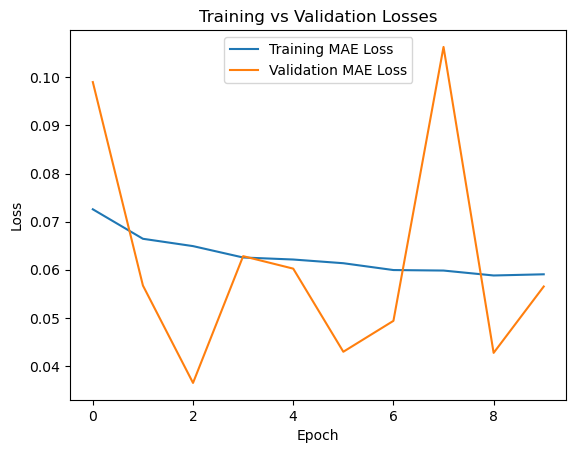

In [21]:
plt.plot(train_mae, label='Training MAE Loss')
plt.plot(val_mae, label='Validation MAE Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

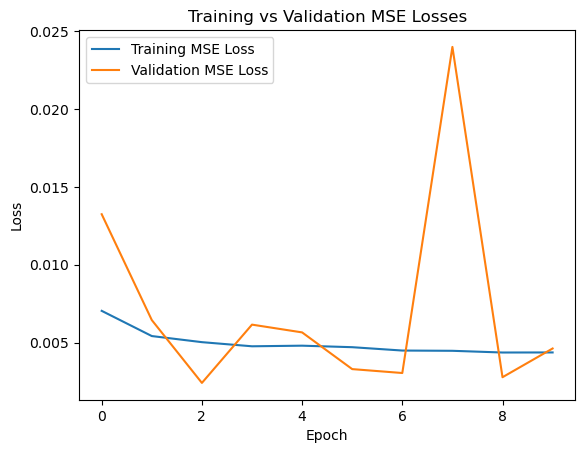

In [22]:
plt.plot(train_mse, label='Training MSE Loss')
plt.plot(val_mse, label='Validation MSE Loss')
plt.title('Training vs Validation MSE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

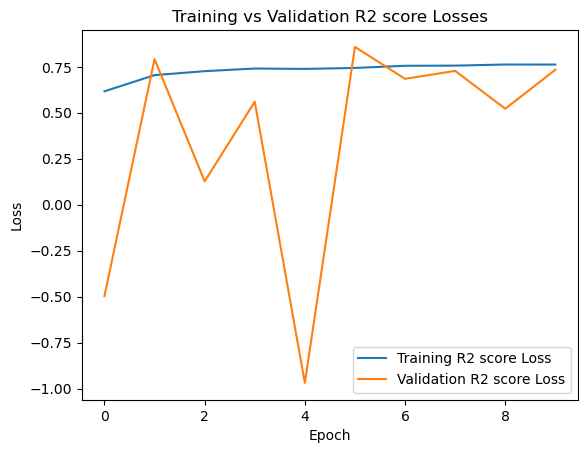

In [23]:
plt.plot(train_r2_score, label='Training R2 score Loss')
plt.plot(val_r2_score, label='Validation R2 score Loss')
plt.title('Training vs Validation R2 score Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [57]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers,dropout):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train.shape[1]
hidden_size = 64
num_layers = 1
rnn_model_one = RNN(input_size, hidden_size, num_layers=3,dropout=0.2)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model_one.parameters(), lr=0.001)

In [58]:
rnn_model_one

RNN(
  (rnn): RNN(8, 64, num_layers=3, bias=0.2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [56]:
summary(rnn_model_one, device=device)

Layer (type:depth-idx)                   Param #
RNN                                      --
├─RNN: 1-1                               21,376
├─Linear: 1-2                            65
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0

In [25]:
num_epochs = 10
train_mse_one,train_mae_one,train_rmse_one,train_r2_score_one = [],[],[],[]
val_mse_one, val_mae_one,val_rmse_one,val_r2_score_one = [],[],[],[]

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = rnn_model_one(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_mse_one.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_mae_one.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_r2_score_one.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    
    for i, (inputs, targets) in enumerate(validation_loader):
        optimizer.zero_grad()
        outputs = rnn_model_one(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    val_mse_one.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_mae_one.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_r2_score_one.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))

with torch.no_grad():
    predicted = rnn_model_one(X_test_tensor.unsqueeze(1))
    print("Test Data Mean Squared Error:", criterion(predicted.squeeze(), y_test_tensor).item())
    print("Test Data Mean Absolute Error:", mean_absolute_error(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))
    print("Test Data R^2 Score:",r2_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Training Epoch [1/10], Loss: 0.0070
Validation Epoch [1/10], Loss: 0.0065
Training Epoch [2/10], Loss: 0.0057
Validation Epoch [2/10], Loss: 0.0030
Training Epoch [3/10], Loss: 0.0057
Validation Epoch [3/10], Loss: 0.0099
Training Epoch [4/10], Loss: 0.0054
Validation Epoch [4/10], Loss: 0.0077
Training Epoch [5/10], Loss: 0.0053
Validation Epoch [5/10], Loss: 0.0044
Training Epoch [6/10], Loss: 0.0053
Validation Epoch [6/10], Loss: 0.0091
Training Epoch [7/10], Loss: 0.0052
Validation Epoch [7/10], Loss: 0.0120
Training Epoch [8/10], Loss: 0.0050
Validation Epoch [8/10], Loss: 0.0096
Training Epoch [9/10], Loss: 0.0049
Validation Epoch [9/10], Loss: 0.0195
Training Epoch [10/10], Loss: 0.0050
Validation Epoch [10/10], Loss: 0.0040
Test Data Mean Squared Error: 0.3636202812194824
Test Data Mean Absolute Error: 0.08333888
Test Data R^2 Score: 0.028533255998660856


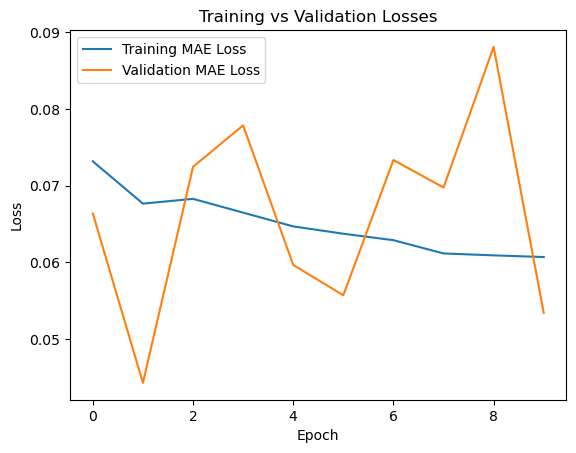

In [26]:
plt.plot(train_mae_one, label='Training MAE Loss')
plt.plot(val_mae_one, label='Validation MAE Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

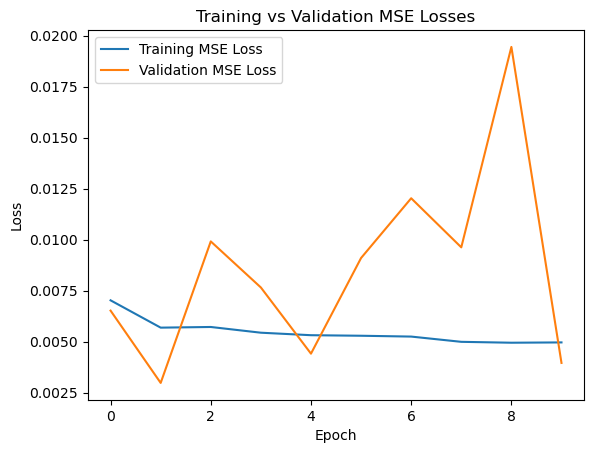

In [27]:
plt.plot(train_mse_one, label='Training MSE Loss')
plt.plot(val_mse_one, label='Validation MSE Loss')
plt.title('Training vs Validation MSE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

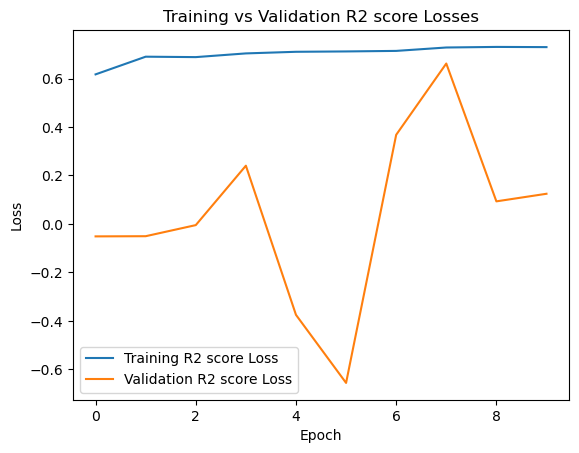

In [50]:
plt.plot(train_r2_score_one, label='Training R2 score Loss')
plt.plot(val_r2_score_one, label='Validation R2 score Loss')
plt.title('Training vs Validation R2 score Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [54]:
torch.save(rnn_model_one.state_dict(), 'rsingh57_ts92_assignment1_part_3_rnn_best_model.h5')

In [40]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train.shape[1]
hidden_size = 64
num_layers = 1
rnn_model_two = RNN(input_size, hidden_size, num_layers=3)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model_two.parameters(), lr=0.002)

In [41]:
rnn_model_two

RNN(
  (rnn): RNN(8, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [29]:
num_epochs = 10
train_mse_two,train_mae_two,train_rmse_two,train_r2_score_two = [],[],[],[]
val_mse_two, val_mae_two,val_rmse_two,val_r2_score_two = [],[],[],[]

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = rnn_model_two(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_mse_two.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_mae_two.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_r2_score_two.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    
    for i, (inputs, targets) in enumerate(validation_loader):
        optimizer.zero_grad()
        outputs = rnn_model_two(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    val_mse_two.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_mae_two.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_r2_score_two.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))

with torch.no_grad():
    predicted = rnn_model_two(X_test_tensor.unsqueeze(1))
    print("Test Data Mean Squared Error:", criterion(predicted.squeeze(), y_test_tensor).item())
    print("Test Data Mean Absolute Error:", mean_absolute_error(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))
    print("Test Data R^2 Score:",r2_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Training Epoch [1/10], Loss: 0.0061
Validation Epoch [1/10], Loss: 0.0083
Training Epoch [2/10], Loss: 0.0058
Validation Epoch [2/10], Loss: 0.0020
Training Epoch [3/10], Loss: 0.0061
Validation Epoch [3/10], Loss: 0.0146
Training Epoch [4/10], Loss: 0.0061
Validation Epoch [4/10], Loss: 0.0089
Training Epoch [5/10], Loss: 0.0060
Validation Epoch [5/10], Loss: 0.0030
Training Epoch [6/10], Loss: 0.0057
Validation Epoch [6/10], Loss: 0.0054
Training Epoch [7/10], Loss: 0.0056
Validation Epoch [7/10], Loss: 0.0085
Training Epoch [8/10], Loss: 0.0056
Validation Epoch [8/10], Loss: 0.0047
Training Epoch [9/10], Loss: 0.0058
Validation Epoch [9/10], Loss: 0.0076
Training Epoch [10/10], Loss: 0.0058
Validation Epoch [10/10], Loss: 0.0031
Test Data Mean Squared Error: 0.3639450669288635
Test Data Mean Absolute Error: 0.0728349
Test Data R^2 Score: 0.027665624366270514


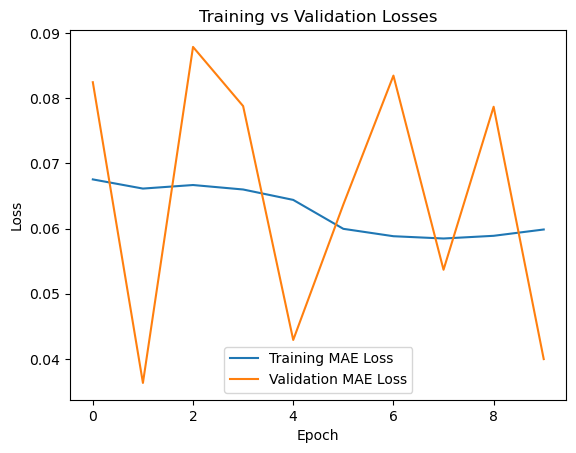

In [30]:
plt.plot(train_mae_two, label='Training MAE Loss')
plt.plot(val_mae_two, label='Validation MAE Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

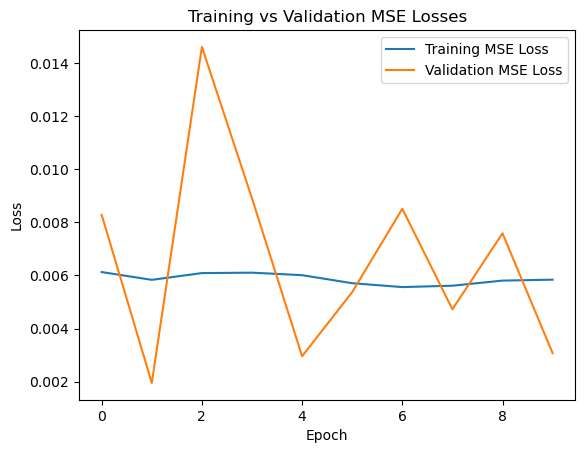

In [31]:
plt.plot(train_mse_two, label='Training MSE Loss')
plt.plot(val_mse_two, label='Validation MSE Loss')
plt.title('Training vs Validation MSE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

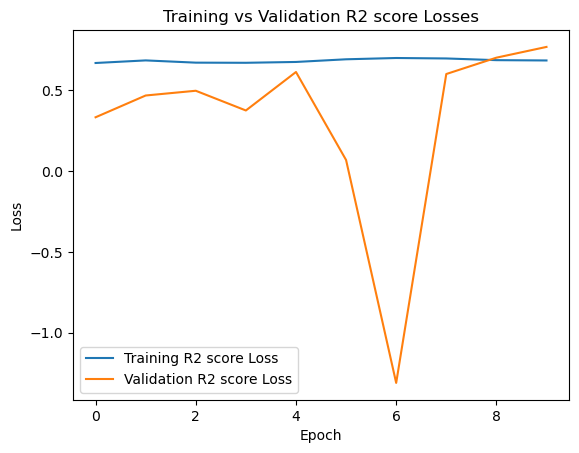

In [52]:
plt.plot(train_r2_score_two, label='Training R2 score Loss')
plt.plot(val_r2_score_two, label='Validation R2 score Loss')
plt.title('Training vs Validation R2 score Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


input_size = X_train.shape[1]
hidden_size = 10
num_layers = 1
rnn_model_three = RNN(input_size, hidden_size, num_layers=3)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model_three.parameters(), lr=0.001)

In [46]:
rnn_model_three

RNN(
  (rnn): RNN(8, 10, num_layers=3, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [47]:
num_epochs = 10
train_mse_three,train_mae_three, train_rmse_three, train_r2_score_three = [],[],[],[]
val_mse_three, val_mae_three,val_rmse_three, val_r2_score_three = [],[],[],[]

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = rnn_model_three(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Training Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_mse_three.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_mae_three.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    train_r2_score_three.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    
    for i, (inputs, targets) in enumerate(validation_loader):
        optimizer.zero_grad()
        outputs = rnn_model_three(inputs.unsqueeze(1))
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
    print(f'Validation Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    val_mse_three.append(mean_squared_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_mae_three.append(mean_absolute_error(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))
    val_r2_score_three.append(r2_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()))

with torch.no_grad():
    predicted = rnn_model_three(X_test_tensor.unsqueeze(1))
    print("Test Data Mean Squared Error:", criterion(predicted.squeeze(), y_test_tensor).item())
    print("Test Data Mean Absolute Error:", mean_absolute_error(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))
    print("Test Data R^2 Score:",r2_score(y_test_tensor.cpu().numpy(), predicted.cpu().numpy()))

Training Epoch [1/10], Loss: 0.0053
Validation Epoch [1/10], Loss: 0.0034
Training Epoch [2/10], Loss: 0.0046
Validation Epoch [2/10], Loss: 0.0058
Training Epoch [3/10], Loss: 0.0046
Validation Epoch [3/10], Loss: 0.0047
Training Epoch [4/10], Loss: 0.0047
Validation Epoch [4/10], Loss: 0.0029
Training Epoch [5/10], Loss: 0.0050
Validation Epoch [5/10], Loss: 0.0118
Training Epoch [6/10], Loss: 0.0050
Validation Epoch [6/10], Loss: 0.0012
Training Epoch [7/10], Loss: 0.0054
Validation Epoch [7/10], Loss: 0.0063
Training Epoch [8/10], Loss: 0.0056
Validation Epoch [8/10], Loss: 0.0133
Training Epoch [9/10], Loss: 0.0058
Validation Epoch [9/10], Loss: 0.0051
Training Epoch [10/10], Loss: 0.0057
Validation Epoch [10/10], Loss: 0.0048
Test Data Mean Squared Error: 0.36329612135887146
Test Data Mean Absolute Error: 0.07484238
Test Data R^2 Score: 0.029399204629193987


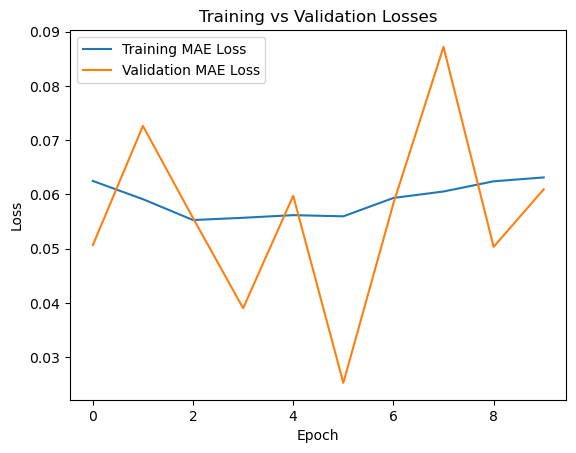

In [48]:
plt.plot(train_mae_three, label='Training MAE Loss')
plt.plot(val_mae_three, label='Validation MAE Loss')
plt.title('Training vs Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

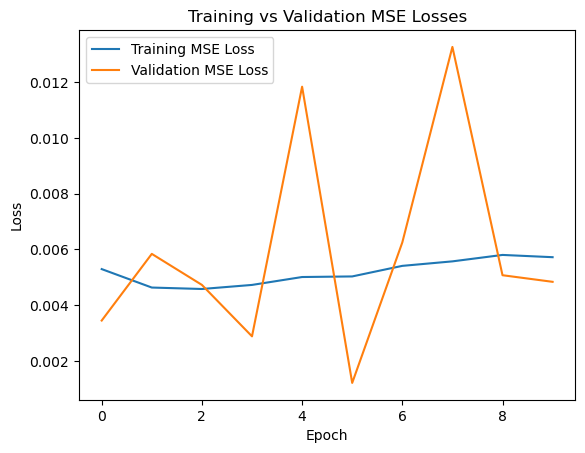

In [49]:
plt.plot(train_mse_three, label='Training MSE Loss')
plt.plot(val_mse_three, label='Validation MSE Loss')
plt.title('Training vs Validation MSE Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

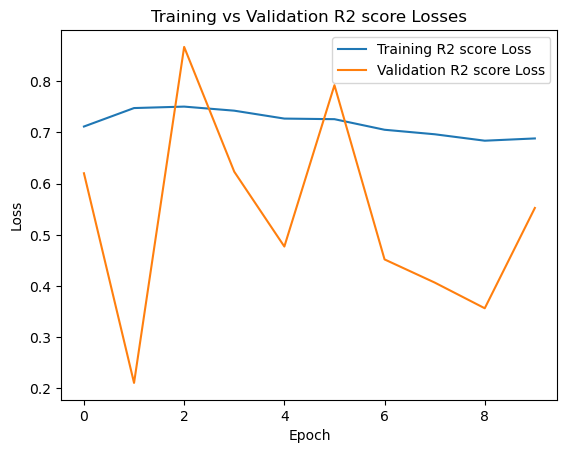

In [53]:
plt.plot(train_r2_score_three, label='Training R2 score Loss')
plt.plot(val_r2_score_three, label='Validation R2 score Loss')
plt.title('Training vs Validation R2 score Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### References

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html
- https://www.kaggle.com/c/nyc-taxi-trip-duration/data
- https://www.kaggle.com/code/belkacemmamou/nyc-taxi-duration-prediction
- https://www.kaggle.com/code/mohankoruprolu/nyc-taxi-analysis
- https://www.kaggle.com/code/smitraval24/new-york-city-taxi-trip-duration
- Part 3 is based on the CSE 574 Machine Learning Assignment 0,1,2,3 and Quiz 5 submission by Tanmay Sharma[ts92, 50545719] and CSE 676 Deep Learning Assignment 0 by Tanmay Sharma [ts92, 50545719]
- 
- 
- 
- 
- 
- 
- 
